# ***Prequestise***


*   The PM2.5 data were available at the following link:

> https://ci.taiwan.gov.tw/dsp/history/iis_airbox/


*   The longitude and latitude of site information can be found in the following links:

> https://github.com/sltzeng/PM2.5_calibration/raw/main/AirBox_station.csv

> https://github.com/sltzeng/PM2.5_calibration/raw/main/AirBox_station.csv


*   We cleaned the data as the steps below and prepared a file named 
"airbox21-01-08.csv" for the analysis here: 
> 1. Removing negative or values larger than 1000 (in ppm). 
> 2. Matching the longitude and latitude with site id.
> 3. Aggregating  the  raw  AirBox  data  into hourly  data  by  averaging  over all  data  for  each  hour  and  each  site.

*   Files for plotting maps are also necessary, which can be found in the folder "shapefile".



# ***Install and Import libraries***

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/'
where = path +'Colab Notebooks/'
ckdir=path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture 
!pip install scikit-fda
!pip install GPy
!pip install geopandas
!pip install geoplot
!pip install rasterio

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -q -c conda-forge cartopy


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████



In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cartopy

In [ ]:
import rasterio
import rasterio.plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import glob
import time
from collections import Counter
import matplotlib.dates as mdates
#import skfda
import geopandas as gpd
import geoplot
from shapely.geometry import Polygon, LineString, Point
pd.options.mode.chained_assignment = None

In [ ]:
!pip install rpy2==3.5.1
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()
base = importr('base')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ro.r('''
mrts0=rabf=function(knot,k,x=NULL)
{
  DIST=function(A,B)
   sqrt(outer(A[,1],B[,1],"-")^2+outer(A[,2],B[,2],"-")^2)

  predict.rabf=function(object,newx,...)
  { 
    if (missing(newx)) return(object)
    x0=newx  
    n=NROW(attr(object,"Xu"))
    ndims=NCOL(x0)
    d=DIST(x0,attr(object,"Xu"))  
    if(ndims==1) H=1/12*d^3
    if(ndims==2) 
      {
       H=1/8*d^2*log(d)
       H[d==0]=0     
      }
    if(ndims==3) H=-1/8*d
    k=NCOL(object);
    kstar=(k-ndims-1)	
    if(kstar>0)
    {  
    X1=H%*%attr(object,"UZ")[1:n,1:kstar]
    B=as.matrix(cbind(1,x0))
    X1=X1-B%*%attr(object,"BBBH")%*%attr(object,"UZ")[1:n,1:kstar]
    X1=X1/sqrt(n)  
    } else X1=NULL
    shift=colMeans(attr(object,"Xu"))    
    X2=cbind(1,x0)
    if(kstar>0) return(as.matrix(cbind(X2,X1)))  else
    return(as.matrix(X2))
  }


  xobs=as.matrix(knot)
  Xu=unique(cbind(xobs)) 
  colnames(Xu)=NULL  
  n=n.Xu=NROW(Xu)
  ndims=NCOL(Xu)    
  if(k<(ndims+1)) stop("k-1 can not be smaller than the number of dimensions!")
  
  d=as.matrix(dist(Xu))   
  root=sqrt(n)
  if(ndims==1) H=1/12*d^3
  if(ndims==2) 
   {
     H=1/8*d^2*log(d)
     H[d==0]=0     
   }
  if(ndims==3) H=-1/8*d   
  B=cbind(1,Xu)
  BBB=solve(t(B)%*%B)%*%t(B)	  
  A=diag(1,n)-B%*%BBB
  AH=H-(H%*%B)%*%BBB
  AHA=AH-t(BBB)%*%(t(B)%*%AH)  
  gamma0=svd(AHA,nu=k-ndims-1,nv=0)$u				#faster

  trueBS=AHA%*%gamma0; rho=sqrt(colSums(trueBS^2))
  X1=t(t(trueBS)/rho)        #+#
  gammas=t(t(A%*%gamma0)/rho)*root
  X2=cbind(1,Xu) 
  X=cbind(X2,X1)

  if(ndims==1) 
  {
    S=rbind(cbind( t(gammas)%*%AHA%*%gammas,0,0),0,0)
	UZ=rbind(cbind(gammas,0,0),0,0)
	UZ[n+1,k-1]=1; 
	UZ[n+2,k]=1/sd(xobs)/sqrt((n-1)/(n))
  }
  if(ndims==2) 
  {
    S=rbind(cbind(t(gammas)%*%AHA%*%gammas,0,0,0),0,0,0)  
	UZ=rbind(cbind(gammas,0,0,0),0,0,0)
	UZ[n+1,k-2]=1; 
	UZ[n+2,k-1]=1/sd(xobs[,1])/sqrt((n-1)/(n))	
	UZ[n+3,k]=1/sd(xobs[,2])/sqrt((n-1)/(n))	
  }      
  if(ndims==3) 
  {
    S=rbind(cbind(t(gammas)%*%AHA%*%gammas,0,0,0,0),0,0,0,0)  
	UZ=rbind(cbind(gammas,0,0,0,0),0,0,0,0)
	UZ[n+1,k-2]=1; 
	UZ[n+2,k-1]=1/sd(xobs[,1])/sqrt((n-1)/(n))	
	UZ[n+3,k]=1/sd(xobs[,2])/sqrt((n-1)/(n))	
	UZ[n+4,k]=1/sd(xobs[,3])/sqrt((n-1)/(n))	
  }       

  obj=X
  attr(obj,"S")=S
  attr(obj,"UZ")=UZ
  attr(obj,"Xu")=Xu  
  attr(obj,"BBBH")=BBB%*%H
  attr(obj,"class")=c("matrix","rabf")
  class(obj)="rabf"
  if(is.null(x))  return(obj) else
  {
   obj0=predict.rabf(obj,x)
   dimnames(obj)=NULL  
   aname=names(attributes(obj))
   attributes(obj0)=c(attributes(obj0), 
       attributes(obj)[setdiff(aname,c("dim","dimnames"))])
   return(obj0)	    
  }
}
''')

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7fa0d87a7300> [RTYPES.CLOSXP]
R classes: ('function',)

# ***Read map and data***

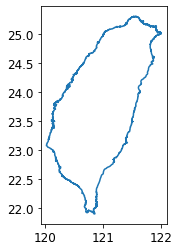

In [ ]:
border = gpd.read_file(os.path.join(where, 'shapfile/TWshapefile.shp'))
border.boundary.plot()
cities_dissolved=border  

In [ ]:
crs_string = "EPSG:3824"
pm25_df = pd.read_csv(os.path.join(where,  'airbox21-01-08.csv')) 
pm25_gdf = gpd.GeoDataFrame(pm25_df, geometry=gpd.points_from_xy(pm25_df.lon, pm25_df.lat), crs=crs_string)
pm25_gdf = pm25_gdf[pm25_gdf.PM25 <= 1000]
#pm25_gdf = pm25_gdf.reset_index(drop=True)
pm25_gdf.head()

,PM25,timestamp,lat,lon,geometry
0,4.900000,2021-01-08_19,24.531,120.853,POINT (120.85300 24.53100)
1,13.636364,2021-01-08_19,22.677,120.526,POINT (120.52600 22.67700)
2,4.727273,2021-01-08_19,24.447,120.721,POINT (120.72100 24.44700)
3,8.583333,2021-01-08_19,25.072,121.205,POINT (121.20500 25.07200)
4,5.636364,2021-01-08_19,24.697,120.891,POINT (120.89100 24.69700)


In [ ]:
def isin_taiwan(x):      
      return x.geometry.within(cities_dissolved.geometry[0])

In [ ]:
pm25_gdf['id'] = np.linspace(1,pm25_gdf.shape[0],pm25_gdf.shape[0])
tmp = pm25_gdf[pm25_gdf.apply(lambda x: isin_taiwan(x), axis=1)]
pm25_gdf = pm25_gdf[pm25_gdf['id'].isin(tmp.id)].reset_index(drop=True)

# ***Plot data and MRTS bases***

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter

#bottom = plt.cm.get_cmap('Oranges', 256)
bottom = ListedColormap('red', 256)
top = plt.cm.get_cmap('viridis', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 100)), bottom(np.linspace(0, 1, 700))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [ ]:
minx = cities_dissolved.bounds.iloc[0,0]
maxx = cities_dissolved.bounds.iloc[0,2]
miny = cities_dissolved.bounds.iloc[0,1]
maxy = cities_dissolved.bounds.iloc[0,3]

In [ ]:
s = pm25_gdf[['lon', 'lat']].to_numpy()
print(f'The number of locations: {s.shape[0]}')

The number of locations: 1830


In [ ]:
resolution = 100
K_TPS = 500
s1, s2 = np.meshgrid(np.linspace(minx, maxx, resolution), np.linspace(miny, maxy, resolution))
s_ = np.vstack((s1.flatten(), s2.flatten())).T
s_tps = np.vstack([s,s_]) 
phi_tps = ro.r["mrts0"](s, K_TPS, s_tps) 
F = phi_tps[0:s.shape[0],:] 
F_ = phi_tps[s.shape[0]:phi_tps.shape[0],:] 

In [ ]:
i = 25
MRS_gdf = gpd.GeoDataFrame(
    pd.DataFrame(pd.DataFrame(F_[:, :i], columns=['MRS'+str(i+1) for i in range(25)])), 
    geometry=gpd.points_from_xy(s_[:,0], s_[:,1]), crs=crs_string
)

In [ ]:
bool_ = MRS_gdf.apply(lambda x: isin_taiwan(x), axis=1)

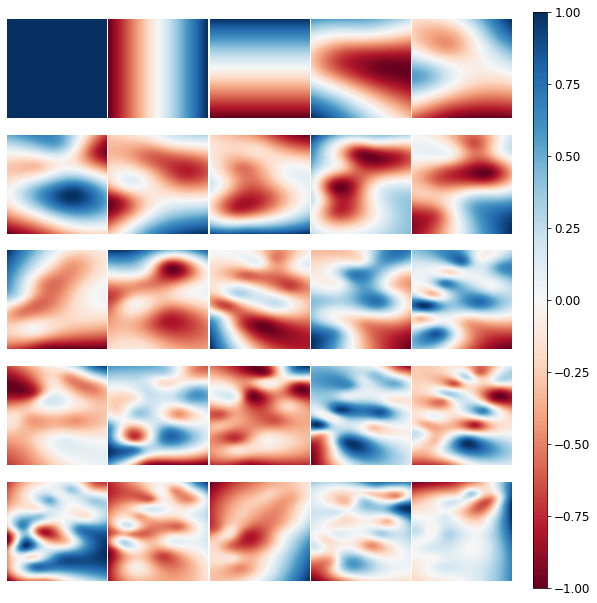

In [ ]:
nrows = 5; ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)

for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    mat = F_[:, i:(i+1)].reshape(resolution, resolution)
    if i == 0:
        mat_ = mat
    else:
        max_, min_ = np.max(mat), np.min(mat)
        mat_ = 2*((mat-min_)/(max_-min_)) -1
    im0 = ax.imshow(mat_ , extent=[0, 1, 0, 1], origin="lower", vmax=1, vmin=-1, cmap='RdBu')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im0, cax=cb_ax)
#plt.savefig(os.path.join(where, 'MRS_demo_PM25.png'), dpi=100, bbox_inches='tight')
#plt.show()

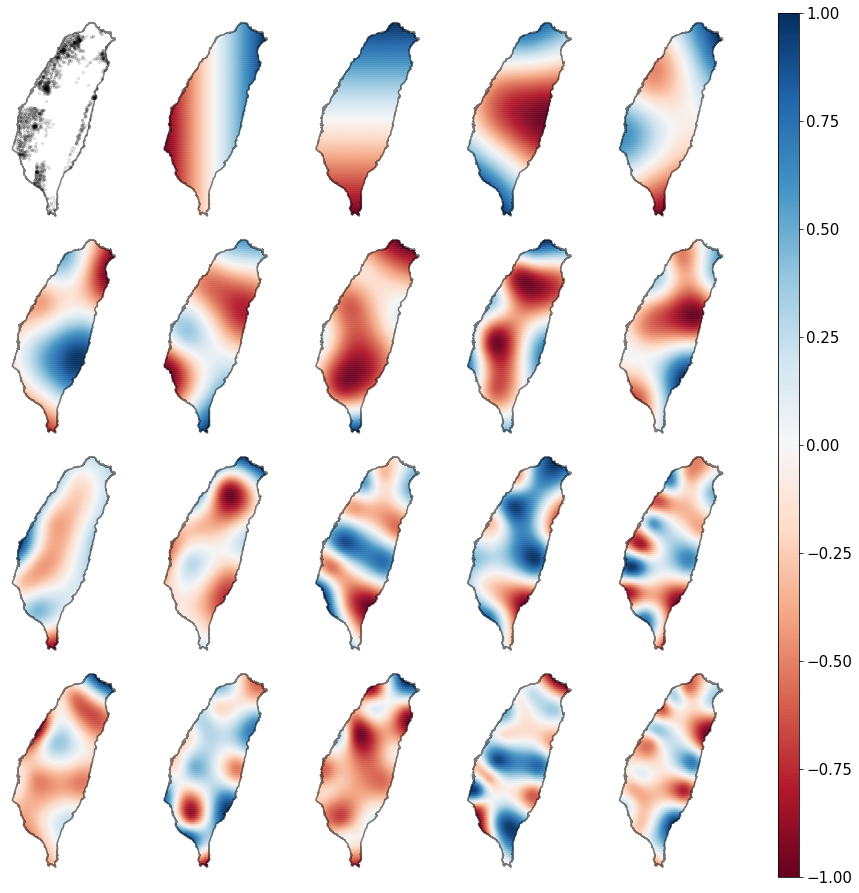

In [ ]:
nrows = 4; ncols = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
cmap = plt.cm.RdBu
cmap.set_bad('white', 1.)

plt.setp(axes, xticks=[], yticks=[])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)

for i, ax in enumerate(axes.flat):
    ax.set_axis_off()

    sub_gdf = MRS_gdf[['MRS'+str(i+1), 'geometry']]
    sub_gdf['MRS'+str(i+1)][-bool_] = np.NaN

    base = cities_dissolved.boundary.plot(color='black', edgecolor='black', alpha=0.5, ax=ax)
    vec = sub_gdf['MRS'+str(i+1)]    
    max_, min_ = np.max(vec), np.min(vec)
    vec = 2*((vec-min_)/(max_-min_)) -1

    im = sub_gdf.plot(column=vec, ax=ax, alpha=.5, s=5, cmap=cmap, vmax=1, vmin=-1, legend=False)
    if i == 0:
         pm25_gdf.plot(ax=ax, alpha=.1, markersize=5, color='black')

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
#cbar = fig.colorbar(im, cax=cb_ax)
cb_ax.tick_params(labelsize=15)   
cbar = fig.colorbar(im0, cax=cb_ax)
plt.savefig(os.path.join(where, 'MRS_demo_PM25_v2.png'), dpi=300, bbox_inches='tight')
plt.show()

# ***Model fitting***


In [ ]:
from sklearn.model_selection import train_test_split, KFold
import itertools
import scipy

In [ ]:
def DeepKriging(input_dim, num_hiddenLayers):
    
    inp = Input((input_dim, ))
        
    x = Dense(100, activation='relu')(inp)
    
    for _ in range(num_hiddenLayers-1):
        x = Dense(100, activation='relu')(x)
        
    out = Dense(1, activation='linear')(x)

    return Model(inp, out)


In [ ]:
NB_START_EPOCHS = 200
BATCH_SIZE = 64

def DeepKriging(input_dim, num_Layers):
    
    inp = Input((input_dim, ))
        
    x = Dense(100, activation='relu')(inp)
        
    for _ in range(num_Layers-1):
        x = Dense(100, activation='relu')(x)
    
    out = Dense(1, activation='linear')(x)

    return Model(inp, out)

def huber(y_true, y_pred):
    return np.mean(np.where(np.abs(y_true - y_pred) <= 1.345, 0.5*(y_true - y_pred)**2, 1.345*((np.abs(y_true-y_pred)) - 0.5*1.345)))

In [ ]:
import gc

K_grids = [ 25, 50, 100, 150, 200, 250 ]
num_layers = [ 2, 3, 4, 5] 


K_Fold = KFold(n_splits=5)
ind_train = np.arange(0, pm25_gdf.shape[0])

response_train = pm25_gdf.PM25

grids = [i for i in itertools.product(K_grids, num_layers)]
loss_K_cv = []


for K, num_layer in grids:
    input_train = F[:, 0:K]

    loss_tmp = []
    for train_ind, valid_ind in K_Fold.split(ind_train):
        response_train_, response_valid_ = response_train[train_ind], response_train[valid_ind]
        input_train_, input_valid_ = input_train[train_ind], input_train[valid_ind]

        checkpoints_dir = where+'ckpt_airbox'

        if not os.path.exists(checkpoints_dir):
            os.makedirs(checkpoints_dir)

        ckpt = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoints_dir, 'best.hdf5'),
            monitor='val_loss', 
            save_best_only=True, 
            verbose=0, mode='min'
        )

        DK_model = DeepKriging(input_train_.shape[1], num_layer)
        DK_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.Huber(1.345))

        DK_model.fit(
            input_train_, response_train_,
            validation_data=(input_valid_, response_valid_),
            epochs=200, batch_size=BATCH_SIZE, verbose=0, callbacks=[ckpt]
        )
        DK_model.load_weights(ckpt.filepath)
        pred_DK = DK_model.predict(input_valid_)
        
        huberL_DK = huber(pred_DK[:,0], response_valid_)
        loss_tmp.append(huberL_DK)
        del DK_model
        gc.collect()

    loss_K_cv.append(np.mean(loss_tmp))
    print(f'[CV-loss] DeepKriging with {num_layer}L and {K} basis functions: {round(np.mean(loss_tmp), 4)}')
        
opt_K, opt_num_layer = grids[np.argmin(loss_K_cv)]

12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 2L and 25 basis functions: 8.0301
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 3L and 25 basis functions: 6.891
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 4L and 25 basis functions: 6.4728
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 5L and 25 basis functions: 6.4711
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 2L and 50 basis functions: 8.0094
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 3L and 50 basis functions: 6.7474
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 4L and 50 basis functions: 5.7341
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 5L and 50 basis functions: 6.2106
12/12 [==============================] - 0s 2ms/step
[CV-loss] DeepKriging with 2L and 10

In [ ]:
pm25_loc_gdf = pm25_gdf.copy()

In [ ]:
opt_K = 100
opt_num_layer = 4
input_vector = F[:, 0:opt_K]
input_vector_ = F_[:, 0:opt_K]
DK_mod = DeepKriging(input_vector.shape[1], opt_num_layer)
DK_mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.Huber(1.345))

checkpoints_dir = os.path.join(checkpoints_dir)

if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

chkp_obj = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoints_dir, 'best.hdf5'), monitor='val_loss', 
    save_best_only=True, verbose=0, mode='min')


In [ ]:
history = DK_mod.fit(
    input_vector, pm25_loc_gdf.PM25, epochs=200, batch_size=BATCH_SIZE, verbose=0,
    validation_split=0.2, callbacks=[chkp_obj])

DK_mod.load_weights(chkp_obj.filepath)

In [ ]:
pm25_loc_gdf['pred'] = DK_mod.predict(input_vector)[:,0]

gdf_pred_sim = gpd.GeoDataFrame(
    pd.DataFrame({'pred': DK_mod.predict(input_vector_)[:,0]}), 
    geometry=gpd.points_from_xy(s_[:,0], s_[:,1]), crs=crs_string)

In [ ]:
bool_ = gdf_pred_sim.apply(lambda x: isin_taiwan(x), axis=1)
gdf_pred_sim.pred[-bool_] = np.NaN

In [ ]:
#customized colorbar
import matplotlib.colors as mcolors
from matplotlib import cm
nb=70
what=np.round(np.sqrt(np.linspace(1,nb, nb))*np.sqrt(nb)-1)
what=np.array(what,dtype=np.int16)
at=list(what)
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1,len(at))[at])
red = np.empty([3,4])
red[:,0]=1.0
red[:,1]=0
red[:,2]=0
red[:,3]=1.0
newcolors = np.vstack([newcolors, red])
levels=np.hstack([np.linspace(0,nb,nb+1),np.linspace(nb,nb+2,3)])
cmap, norm = mcolors.from_levels_and_colors(list(levels), newcolors)

/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


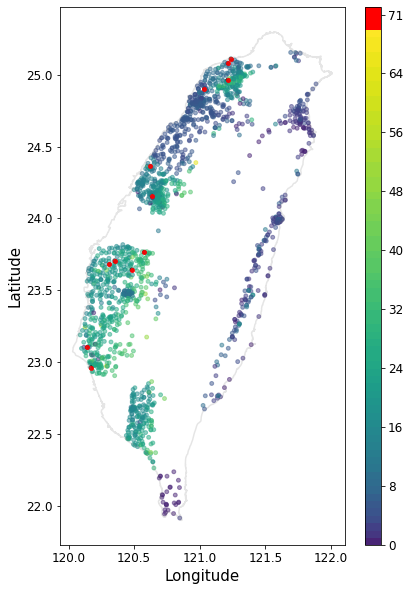

In [ ]:
plt.rc('axes',labelsize=15)
plt.rc('ytick',labelsize=12)
plt.rc('xtick',labelsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 10))
base = cities_dissolved.boundary.plot(color='gray', edgecolor='white', alpha=0.2, ax=ax)
divider = make_axes_locatable(base)
cax = divider.append_axes("right", size="5%", pad=0.1)


pm25_loc_gdf.plot(
    column=pm25_loc_gdf.PM25, ax=base, alpha=.5, cax=cax, legend=True, markersize=15, cmap=cmap, norm=norm, vmin=0, vmax=70)
pm25_loc_gdf[pm25_loc_gdf.PM25 > 70].plot(
    column=pm25_loc_gdf.PM25[pm25_loc_gdf.PM25 > 70], ax=base, alpha=.9, legend=True, markersize=15, color='red')
plt.savefig(os.path.join(where, 'airbox_data.png'), dpi=300, bbox_inches='tight')

base.set(xlabel="Longitude", ylabel="Latitude")
base.xaxis.set_major_locator(MultipleLocator(0.5))
base.xaxis.set_minor_locator(MultipleLocator(1))
plt.savefig(os.path.join(where, 'airbox_data.png'), dpi=300, bbox_inches='tight')

# ***Predicted Surface Using Various Resolutions***

313/313 [==============================] - 0s 1ms/step


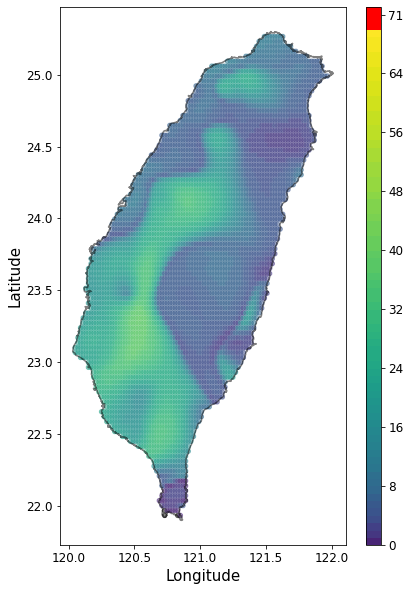

In [ ]:
opt_K = 100      #change this number for results of different K
opt_num_layer = 4

input_vector = F[:, 0:opt_K]
input_vector_ = F_[:, 0:opt_K]
DK_mod = DeepKriging(input_vector.shape[1], opt_num_layer)
DK_mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.Huber(1.345))

#checkpoints_dir = os.path.join(checkpoints_dir)

if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

chkp_obj = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoints_dir, 'best.hdf5'), monitor='val_loss', 
    save_best_only=True, verbose=0, mode='min')

history = DK_mod.fit(
    input_vector, pm25_loc_gdf.PM25, epochs=200, batch_size=BATCH_SIZE, verbose=0,
    validation_split=0.2, callbacks=[chkp_obj])

DK_mod.load_weights(chkp_obj.filepath)

pm25_loc_gdf['pred'] = DK_mod.predict(input_vector)[:,0]

gdf_pred_sim = gpd.GeoDataFrame(
    pd.DataFrame({'pred': DK_mod.predict(input_vector_)[:,0]}), 
    geometry=gpd.points_from_xy(s_[:,0], s_[:,1]), crs=crs_string)


gdf_pred_sim.pred[-bool_] = np.NaN


fig, ax = plt.subplots(1, 1, figsize=(6, 10))

base = cities_dissolved.boundary.plot(color='black', edgecolor='black', alpha=0.5, ax=ax)
divider = make_axes_locatable(base)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf_pred_sim.plot(column=gdf_pred_sim.pred, ax=base, alpha=.5, cax=cax, legend=True, s=20, cmap=cmap, norm=norm, vmin=0, vmax=70)

base.set(xlabel="Longitude", ylabel="Latitude")
base.xaxis.set_major_locator(MultipleLocator(0.5))
base.xaxis.set_minor_locator(MultipleLocator(1))
plt.savefig(os.path.join( where+'fitted'+ str(opt_K) +'.png'), dpi=300, bbox_inches='tight')